# Train model

Train and fine-tune a headless MobileNet V3 on a target image dataset directory

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential

from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
import os
from pathlib import Path
import logging
import pandas as pd
import sqlalchemy as sqa

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.propagate = False

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12


In [2]:
# PARAMETERS
# Model Parameters
image_size = (224, 224)
batch_size = 16
dropout_rate = 0.2

epochs = {
    'top_layer': 500,
    'fine_tuning': 500
}

learning_rates = {
    'top_layer': 0.0001,
    'fine_tuning': 0.000005
}

fine_tune_unfreeze_frac = 0.3


# Data parameters
db_container = "metadata_db"
db_user = "pguser"
db_password = "pgpassword"
db_port = 5432
db_database = "metadata"
db_prefix = "postgresql"

metadata_tbl = "base_images"
datasets_tbl = "datasets"
dataset_img_tbl = "dataset_images"

dataset_name = "test_multi_example"

In [3]:
db_con_str = f"{db_prefix}://{db_user}:{db_password}@{db_container}:{db_port}/{db_database}"
db_engine = sqa.create_engine(db_con_str)

input_shape = (*image_size, 3)

In [4]:
with db_engine.connect() as con:
    df_dataset = pd.read_sql_query(f"""
                                   SELECT * FROM {datasets_tbl}
                                   WHERE name = '{dataset_name}'
                                   """, con, index_col='name')
    df_imgs = pd.read_sql_query(f"""
                                SELECT * FROM {dataset_img_tbl}
                                LEFT JOIN {metadata_tbl} ON {dataset_img_tbl}.image_name = {metadata_tbl}.image_name
                                WHERE dataset_name = '{dataset_name}'
                                """
                                , con, index_col='image_name')
    
ds_config = df_dataset.loc[dataset_name].to_dict()
ds_config['has_test'] = ds_config['test_frac'] > 0
ds_config['has_val'] = ds_config['validation_frac'] > 0
ds_config

{'target_dir': '/home/code/datasets/pipeline_v1/test_multi_dataset',
 'description': 'First example with 50 values from each class and multiclass labeling',
 'validation_frac': 0.2,
 'test_frac': 0.0,
 'label_method': 'MULTI',
 'has_test': False,
 'has_val': True}

In [5]:
train_dir = os.path.join(ds_config['target_dir'], 'train')
test_dir = os.path.join(ds_config['target_dir'], 'test')
val_dir = os.path.join(ds_config['target_dir'], 'validation')

In [16]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size,
                                                            label_mode='categorical')

val_dataset = None
if ds_config['has_val']:
    val_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')

test_dataset = None
if ds_config['has_test']:
    test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                              batch_size=batch_size,
                                                              shuffle=True,
                                                              image_size=image_size,
                                                              label_mode='categorical')

Found 160 files belonging to 4 classes.
Found 40 files belonging to 4 classes.


In [19]:
class_names

['negative_general_plant',
 'negative_random_picture',
 'negative_similar_plant',
 'positive']

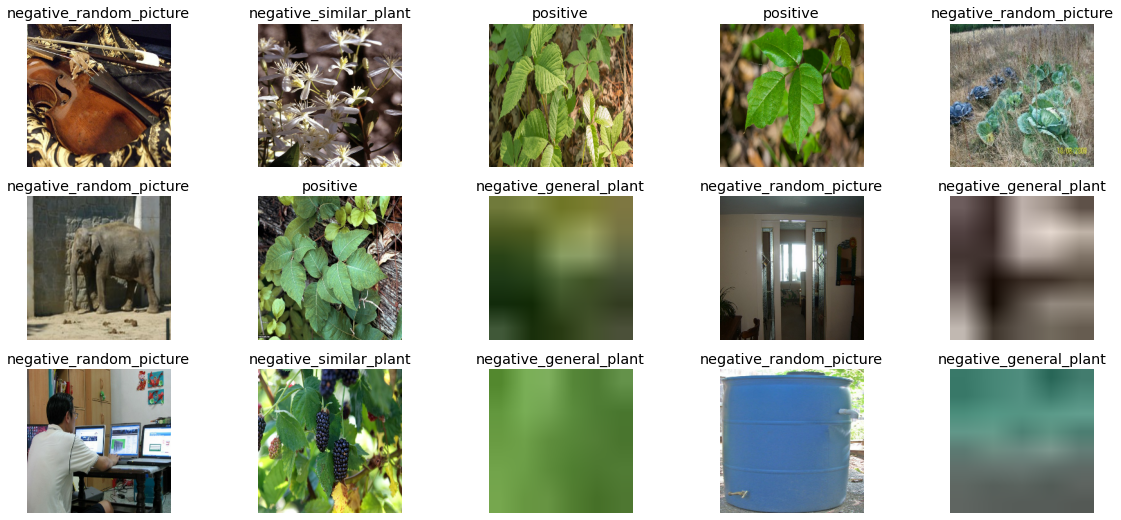

In [22]:
class_names = train_dataset.class_names
n_classes = len(class_names)
y_ims = 3
x_ims = 5

plt.figure(figsize=(x_ims*4, y_ims*3))
for images, labels in train_dataset.take(1):
  for i in range(y_ims*x_ims):
    ax = plt.subplot(y_ims, x_ims, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i].numpy().argmax()])
    plt.axis("off")

## Processing layers

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

### Image augmentation

In [27]:
image_aug = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

### Mobilenet

In [28]:
mobilenet_large = MobileNetV3Large(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg',
                                   include_preprocessing=True,
                                   dropout_rate=dropout_rate)

mobilenet_large.trainable = False
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [29]:
def build_model(mobilenet):
    inputs = Input(shape=input_shape)
    x = image_aug(inputs)
    x = mobilenet(x, training=False)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(n_classes, activation='softmax')(x)
    
    return(Model(inputs, outputs))
    

In [30]:
model = build_model(mobilenet_large)

In [31]:
model.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
              loss=CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [32]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(patience=3, factor=1./3.)
callbacks = [early_stopping, reduce_lr]

In [38]:
kwargs = {
    'epochs': epochs['top_layer'],
    'callbacks': callbacks
}
if ds_config['has_val']:
    kwargs['validation_data'] = val_dataset

history = model.fit(train_dataset, **kwargs)

Epoch 1/500
10/10 [==============================] - 6s 142ms/step - loss: 0.0484 - accuracy: 0.9937 - val_loss: 0.3242 - val_accuracy: 0.8750
Epoch 2/500
10/10 [==============================] - 1s 64ms/step - loss: 0.0431 - accuracy: 0.9875 - val_loss: 0.3207 - val_accuracy: 0.8750
Epoch 3/500
10/10 [==============================] - 1s 66ms/step - loss: 0.0347 - accuracy: 0.9937 - val_loss: 0.3206 - val_accuracy: 0.8750
Epoch 4/500
10/10 [==============================] - 1s 63ms/step - loss: 0.0332 - accuracy: 0.9937 - val_loss: 0.3190 - val_accuracy: 0.9000
Epoch 5/500
10/10 [==============================] - 1s 62ms/step - loss: 0.0287 - accuracy: 1.0000 - val_loss: 0.3172 - val_accuracy: 0.9000
Epoch 6/500
10/10 [==============================] - 1s 71ms/step - loss: 0.0280 - accuracy: 1.0000 - val_loss: 0.3189 - val_accuracy: 0.9000
Epoch 7/500
10/10 [==============================] - 1s 59ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 0.3093 - val_accuracy: 0.9000
Epoch

## Fine-tune models

In [39]:
unfreeze = int(len(mobilenet_large.layers) * fine_tune_unfreeze_frac)

print(f"Mobilenet-large: Unfreezing {unfreeze} of {len(mobilenet_large.layers)} layers")
mobilenet_large.trainable = True
for layer in mobilenet_large.layers[:-unfreeze]:
    layer.trainable = False

Mobilenet-large: Unfreezing 81 of 270 layers


In [40]:
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_2[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [41]:
model.compile(optimizer=RMSprop(learning_rate=learning_rates['fine_tuning']),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [42]:
print(len(history.epoch))

21


In [44]:
base_epochs = len(history.epoch)
history_FT = model.fit(train_dataset,
                       validation_data=val_dataset,
                       epochs=epochs['fine_tuning'] + base_epochs,
                       initial_epoch=history.epoch[-1],
                       callbacks=callbacks)

Epoch 21/521
10/10 [==============================] - 1s 65ms/step - loss: 0.0155 - accuracy: 1.0000 - val_loss: 0.3025 - val_accuracy: 0.9000
Epoch 22/521
10/10 [==============================] - 1s 66ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.3023 - val_accuracy: 0.9000
Epoch 23/521
10/10 [==============================] - 1s 64ms/step - loss: 0.0143 - accuracy: 0.9937 - val_loss: 0.3024 - val_accuracy: 0.9000
Epoch 24/521
10/10 [==============================] - 1s 70ms/step - loss: 0.0146 - accuracy: 0.9937 - val_loss: 0.3026 - val_accuracy: 0.9000
Epoch 25/521
10/10 [==============================] - 1s 61ms/step - loss: 0.0096 - accuracy: 1.0000 - val_loss: 0.3025 - val_accuracy: 0.9000
Epoch 26/521
10/10 [==============================] - 1s 61ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.3025 - val_accuracy: 0.9000
Epoch 27/521
10/10 [==============================] - 1s 63ms/step - loss: 0.0091 - accuracy: 1.0000 - val_loss: 0.3025 - val_accuracy: 0.9000

## Analyze history

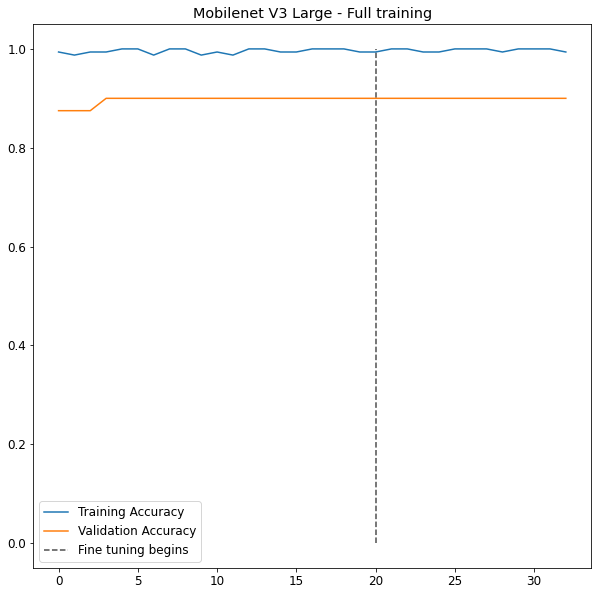

In [46]:
plt.figure(figsize=(10,10))

total_history = {}
for metric in ['accuracy', 'val_accuracy']:
    total_history[metric] = history.history[metric] + history_FT.history[metric]

ax = plt.subplot(1,1,1)
plt.plot(total_history['accuracy'], label='Training Accuracy')
plt.plot(total_history['val_accuracy'], label='Validation Accuracy')
y_min, y_max = (0, 1)
plt.vlines(base_epochs-1, ymin=y_min, ymax=y_max, label='Fine tuning begins', linestyles='--', colors=[0.3]*3)
plt.title("Mobilenet V3 Large - Full training")
plt.legend()


plt.show()